In [1]:
import h5py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
quotes = pd.read_hdf("data/quotes/quotes_pol_allpol1.h5")

In [3]:
elec = pd.read_parquet("data/elec/leg_shares.parquet")

## Step 1: compute monthly share of articles with quotes per political nuance

In [4]:
# Filter quotes to only include political alignments from elec dataframe
valid_alignments = elec['alignement_politique'].unique()
filtered_quotes = quotes[quotes['alignement_politique'].isin(valid_alignments)].copy()

# Convert date to datetime if it isn't already
if not pd.api.types.is_datetime64_any_dtype(filtered_quotes['date']):
    filtered_quotes['date'] = pd.to_datetime(filtered_quotes['date'])

# Extract month from date
filtered_quotes['month'] = filtered_quotes['date'].dt.to_period('M')

# Count text_ids by month and political alignment
counts = filtered_quotes.groupby(['month', 'journal', 'alignement_politique'])['text_id'].nunique().reset_index()

# Get total counts per month
total_counts = filtered_quotes.groupby(['month', 'journal'])['text_id'].nunique().reset_index()
total_counts.rename(columns={'text_id': 'total_text_id'}, inplace=True)

# Merge the counts with total counts
model_data = pd.merge(counts, total_counts, on=['month', 'journal'])

# Calculate share and cleanup the dataframe
model_data['art_share'] = model_data['text_id'] / model_data['total_text_id']
model_data = model_data[['month', 'journal', 'alignement_politique', 'art_share']].copy()

## Step 2: identify electoral cycles

In [5]:
legi_dates = [
    "21/06/1981",
    "16/03/1986",
    "11/06/1988",
    "28/03/1993",
    "01/06/1997",
    "16/06/2002",
    "17/06/2007",
    "17/06/2012",
    "18/06/2017",
    "19/06/2022",
    "06/07/2024"]

In [6]:
# Remove entries older than the earliest election in the dataset
legi_dates = pd.to_datetime(legi_dates, format="%d/%m/%Y").to_period('M').sort_values()
model_data = model_data[model_data['month'] >= min(legi_dates)].copy().reset_index()

In [7]:
# Find the year of the latest election
def find_last_election_year(current_month):
    relevant_elections = legi_dates[legi_dates <= current_month]

    if not relevant_elections.empty:
        return relevant_elections.max().year
    else:
        return pd.NA

model_data['last_election'] = model_data['month'].apply(find_last_election_year)
model_data['last_election'] = pd.to_datetime(model_data['last_election'], format="%Y")

## Step 3: merge with electoral data

In [8]:
elec = elec.groupby('alignement_politique', as_index=False).sum()
elec.drop(columns='candidat', inplace=True)
elec = elec.melt(id_vars=['alignement_politique'], var_name='last_election', value_name='votes_share')
elec['last_election'] = pd.to_datetime(elec['last_election'], format="%Y")

In [9]:
model_data = pd.merge(model_data, elec, on=['alignement_politique', 'last_election'], how='left')
model_data.drop(columns=['last_election', 'index'], inplace=True)

## Step 4: governement dummy
Comment traiter les cohabitations ? En l'état le bonus est seulement accordé à la nuance au gouvernement.

- **centre**
  - 19/06/2017 - 31/12/2024
- **centredroite_droite**
  - 20/03/1986 - 10/05/1988
  - 29/03/1993 - 02/06/1997
  - 06/05/2002 - 10/05/2012
- **centregauche_gauche**
  - 22/06/1981 - 20/03/1986
  - 10/05/1988 - 29/03/1993
  - 02/06/1997 - 06/05/2002
  - 15/05/2012 - 19/06/2017

In [10]:
gov_periods = {
    "centre": [("2017-06-19", "2024-12-31")],
    "centredroite_droite": [
        ("1986-03-20", "1988-05-10"),
        ("1993-03-29", "1997-06-02"),
        ("2002-05-06", "2012-05-10"),
    ],
    "centregauche_gauche": [
        ("1981-06-22", "1986-03-20"),
        ("1988-05-10", "1993-03-29"),
        ("1997-06-02", "2002-05-06"),
        ("2012-05-15", "2017-06-19"),
    ],
    "extremedroite_droiteradicale": [],
    "extremegauche_gaucheradicale": [],
    "autre": [],
}

In [11]:
all_start_dates = [pd.to_datetime(start) for periods in gov_periods.values() for start, _ in periods]
all_end_dates = [pd.to_datetime(end) for periods in gov_periods.values() for _, end in periods]
min_date = min(all_start_dates).replace(day=1)
max_date = max(all_end_dates).replace(day=1)
all_months = pd.date_range(start=min_date, end=max_date, freq="MS")

data = []

for alignment, periods in gov_periods.items():
    active_months = pd.Series(0, index=all_months)
    for start, end in periods:
        period_range = pd.date_range(
            start=pd.to_datetime(start).replace(day=1),
            end=pd.to_datetime(end).replace(day=1),
            freq="MS"
        )
        active_months.loc[period_range] = 1

    df = pd.DataFrame({
        "month": active_months.index.to_period('M'),
        "alignement_politique": alignment,
        "government": active_months.values
    })
    data.append(df)

gov_dummies = pd.concat(data)
gov_dummies.sort_values(by=["month", "alignement_politique"], inplace=True)
gov_dummies.reset_index(drop=True, inplace=True)

In [12]:
model_data = pd.merge(model_data, gov_dummies, on=['alignement_politique', 'month'], how='left')

## Step 5: regression
Les modèles estimés sont de la forme $Y_{ij} = \alpha_jG_i + \beta_{ij}T_i$ avec :
- $Y_{ij}$ est la proportion des articles avec des citations de la nuance politique $i$ dans le journal $j$ (avec $\sum_{i=1}^{n} Y_{ij} = 1$)
- $G_i$ est une indicatrice valant 1 si le Premier ministre appartient à la nuance politique $i$
- $T_i$ est la proportion des voix obtenue par les candidats de la nuance politique $i$ au premier tour des précédentes élections législatives

On estime donc...
- $\alpha_j$ la prime que le journal $j$ accorde à la nuance politique au pouvoir, sous la forme d'une fraction fixe des articles avec citation
- $\beta_{ij}$ la pondération des résultats électoraux de la nuance politique $i$ par le journal $j$

L'hypothèse implicite est $\beta_{ij} = 1 - \alpha_j$ : les nuances politiques sont représentées identiquement à leur poids électoral une fois qu'on élimine les articles avec citations couvrant l'action gouvernementale.

In [13]:
results = {}
pvalues = {}

for alignement in model_data["alignement_politique"].unique():
    results[alignement] = {}
    pvalues[alignement] = {}
    
    for journal in model_data["journal"].unique():
        subset = model_data[
            (model_data["alignement_politique"] == alignement) &
            (model_data["journal"] == journal)]
        
        if len(subset) >= 3:
            X = subset[["votes_share", "government"]]
            y = subset["art_share"]
            
            model = sm.OLS(y, X).fit(cov_type='HC3')
            y_pred = model.predict(X)
            mean_relative_residual = ((y_pred - y) / y).mean()
            
            results[alignement][journal] = {
                "r_squared": model.rsquared,
                "mean_residual": mean_relative_residual}
            
            pvalues[alignement][journal] = model.pvalues.to_dict()
            
        else:
            results[alignement][journal] = {
                "r_squared": None,
                "mean_residual": None}
            pvalues[alignement][journal] = {
                "votes_share": None,
                "government": None}

In [14]:
r2_table = pd.DataFrame({
    alignement: {journal: results[alignement][journal]['r_squared'] for journal in results[alignement]}
    for alignement in results}).T

bias_table = pd.DataFrame({
    alignement: {journal: results[alignement][journal]['mean_residual'] for journal in results[alignement]}
    for alignement in results}).T

pval_votes_share = pd.DataFrame({
    alignement: {journal: pvalues[alignement][journal].get('votes_share') for journal in pvalues[alignement]}
    for alignement in pvalues}).T

pval_government = pd.DataFrame({
    alignement: {journal: pvalues[alignement][journal].get('government') for journal in pvalues[alignement]}
    for alignement in pvalues}).T

Almost all coefficients for the share of votes at legislatives elections and presence in the governement are highly significant.

In [15]:
pval_votes_share.style

,Le Figaro,Le Monde,La Croix,Libération,Mediapart
autre,0.000000,0.000000,0.000000,0.000000,0.000071
centre,0.000000,0.000000,0.000000,0.000000,0.000000
centredroite_droite,0.000000,0.000000,0.000000,0.000000,0.000000
centregauche_gauche,0.000000,0.000000,0.000000,0.000000,0.000000
extremedroite_droiteradicale,0.000000,0.000000,0.000000,0.000000,0.000000
extremegauche_gaucheradicale,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
pval_government.style

,Le Figaro,Le Monde,La Croix,Libération,Mediapart
autre,nan,nan,nan,nan,nan
centre,0.000000,0.000000,0.000002,0.000000,0.000210
centredroite_droite,0.000000,0.000000,0.000000,0.000000,0.137882
centregauche_gauche,0.000000,0.000000,0.000000,0.000000,0.000000
extremedroite_droiteradicale,nan,nan,nan,nan,nan
extremegauche_gaucheradicale,nan,nan,nan,nan,nan


All journals except Médiapart closely adhere to the representativity norm for non-extreme political alignments, with $R^2$ values exceeding 90%. Médiapart follows this norm to a lesser extent, with $R^2$ values ranging from 64% to 83.5%.

For the far right, all journals reflect its vote share to a similar degree, with $R^2$ values between 65% and 77% — highest for Le Figaro, lowest for La Croix.

The representativity norm appears slightly less consistent for the far left, with $R^2$ values ranging from 53% to 77%, again highest for Le Figaro and lowest for La Croix.

Possible explanations: the number of articles with quotes is driven by...
- The number of seats in the Assemblée Nationale, which tends to better reflect the scores of dominant political parties.
- The anticipated scores at the presidential élection.

Of note, the time periods covered vary across journals!

*NB: not shown here is that the government control has negligible effect.*

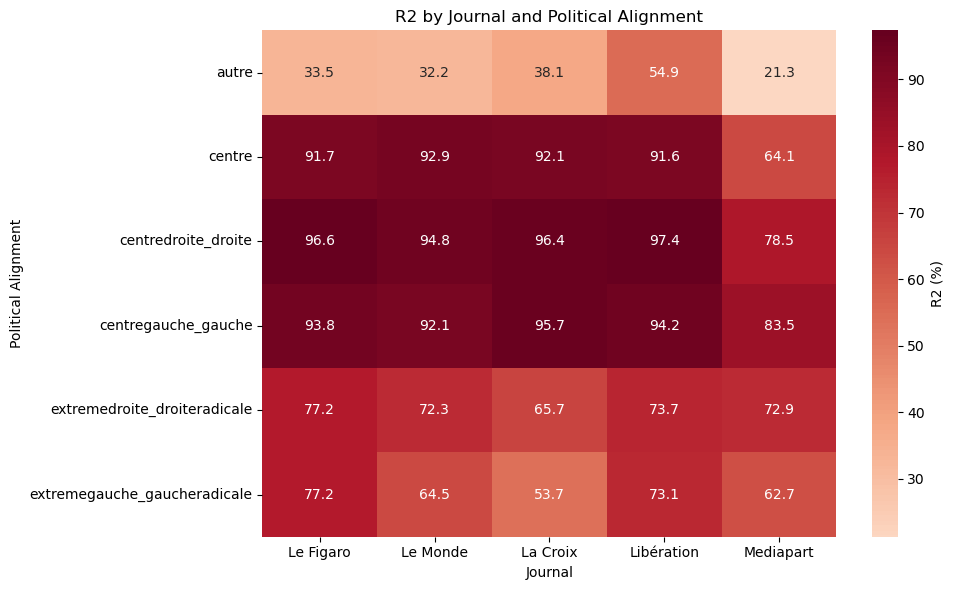

In [17]:
#r2_table.style.format("{:.4f}")

plt.figure(figsize=(10, 6))
sns.heatmap(100*r2_table, annot=True, fmt=".1f", cmap="RdBu_r", center=0, cbar_kws={'label': 'R2 (%)'})
plt.title("R2 by Journal and Political Alignment")
plt.ylabel("Political Alignment")
plt.xlabel("Journal")
plt.tight_layout()
plt.show()

The table below presents the mean relative residuals ($MRR$), indicating the direction and magnitude of prediction error as a percentage of the true value:

$$\text{Mean Relative Residual} = \frac{1}{n} \sum_{i=1}^{n} \frac{\hat{y}_i - y_i}{y_i}$$

A positive $MRR$ indicates that the model overpredicts the share of articles with quotes, i.e., it overestimates a journal's adherence to the representativity norm for the given political alignment ($\hat{y}_i ≥ y_i$). This means the journal publishes fewer articles with quotes from that political alignment than expected based on the norm.

To simplify interpretation, values in the table are inverted: a positive value now signals overrepresentation, and a negative value signals underrepresentation.
- *Le Figaro* and *Le Monde* display similar patterns: they broadly align with the norm for the conventional right, slightly favor the conventional left, slightly penalize the extremes, and strongly favor the center.
- *La Croix* stands out for imposing the strongest penalty on the far right—the most pronounced underrepresentation among all journals.
- *Libération* notably penalizes both the center and the far right.
- *Médiapart* underrepresents the conventional and far right, while favoring the far left.


*NB: Government control has a notable moderating effect here—halving the MRR for the center, leaving the right mostly unchanged, and slightly increasing it for the left.*

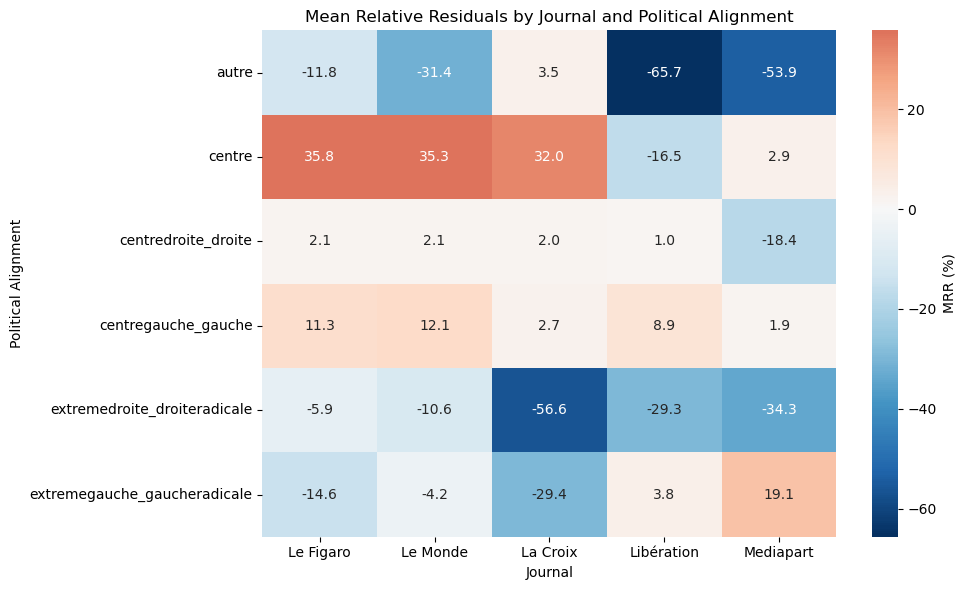

In [18]:
# (-100*bias_table).style.format("{:.1f}")

plt.figure(figsize=(10, 6))
sns.heatmap(-100*bias_table, annot=True, fmt=".1f", cmap="RdBu_r", center=0, cbar_kws={'label': 'MRR (%)'})
plt.title("Mean Relative Residuals by Journal and Political Alignment")
plt.ylabel("Political Alignment")
plt.xlabel("Journal")
plt.tight_layout()
plt.show()